In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

In [2]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/cranmer/active_sciencing/yadage/yadage"
    }
});

<IPython.core.display.Javascript object>

In [3]:
import distr
import common
import plots

In [4]:
import models.model_weinberg_yadage as model

In [5]:
science_ndata = 20
science_theta_nature = 1.0

In [6]:
def collect_data(phi,ndata, widget = None):
    return model.simulator(science_theta_nature,phi,ndata, widget, delay = 2)

In [7]:
def calculate_posterior(prior,data,phi):
    posterior = common.calculate_posterior(
                            prior,data,phi,
                            lnprob_args = model.details_likelihood_settings,
                            n_chainlen = 50
    )
    maximum_a_post = posterior.map(model.details_map_bins)
    
    print 'Best Theta: ', maximum_a_post
    return posterior, maximum_a_post

In [8]:
def design_next_experiment(prior):
        eig_kwargs = {'emcee_kwargs' : {
                      'n_chainlen': 50,
                      'lnprob_args': model.details_likelihood_settings},
                  'sim_n_data': science_ndata,
                  'map_bins': model.details_map_bins}
    res_gp   = common.design_next_experiment_bayesopt(prior,model.phi_range,eig_kwargs, n_totalcalls = 7)
    res_next_phi = res_gp[0].x[0]
    
    print 'Next Phi: ', res_next_phi
    return res_gp,res_next_phi

In [9]:
import science_loop_widget
import yadage_widget
from ipywidgets import widgets
science_wdg = science_loop_widget.loopwidget()
collect_ui  = yadage_widget.WorkflowWidget(None)
widgets.HBox([science_wdg.view,collect_ui])

<IPython.core.display.Javascript object>


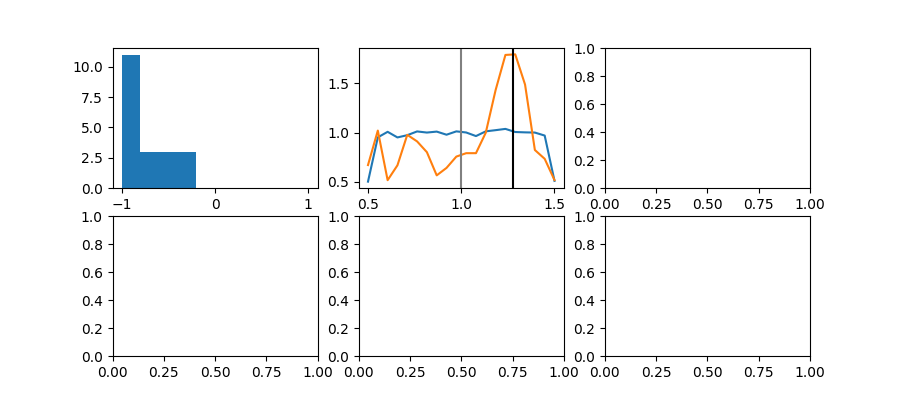

In [10]:
n_science_iterations = 2
fig,axarr = plt.subplots(n_science_iterations,3)
fig.set_size_inches(9,4)

# Running the Science Loop

In [ ]:
# initial experimental settings and uninformative prior
loop_phi = 47
loop_prior = distr.Distribution('prior',range = model.theta_range)

science_history = []
for i in range(n_science_iterations):
        ## 1. Perform Experiment
    science_wdg.toggle(0)
    loop_data = collect_data(loop_phi,science_ndata, widget = collect_ui)
    plots.plot_data(loop_data,model.data_range, ax = axarr[i][0])
    fig.canvas.draw()

    ## 2. Calculate the Posterior
    science_wdg.toggle(1)
    loop_posterior, loop_best_theta = calculate_posterior(loop_prior,loop_data,loop_phi)
    plots.plot_posterior(loop_prior,loop_posterior,loop_best_theta,science_theta_nature, model.theta_range, ax = axarr[i][1])
    fig.canvas.draw()

    ## 3. Design Next Experiment
    science_wdg.toggle(2)
    loop_res_gp, loop_next_phi = design_next_experiment(loop_posterior)

    plots.plot_bayes(loop_res_gp,phi_range = model.phi_range, ax = axarr[i][2])
    fig.canvas.draw()

    science_history.append([loop_data,loop_prior,loop_posterior,loop_best_theta,science_theta_nature,loop_res_gp])
    
    ## 5. Update our Prior and experimental settings
    loop_prior = loop_posterior
    loop_phi   = loop_next_phi
    
    time.sleep(5) # appreciate plots!

Taking Data... 1.0 47 20
Calculate Posterior...
Best Theta:  1.275
Design Next Experiment...
2017-06-09 14:01:42.018806 EIG via 4 parallel experiments with [theta,phi] 1.275 49.6702983901
